## Sporting Events DFD

Logan Gall, gall0487

Attributions/Assistance:
Laure Briol,
Gregory Kohler,
ESRI Arcpy documentation,
ChatGPT,
LucidChart

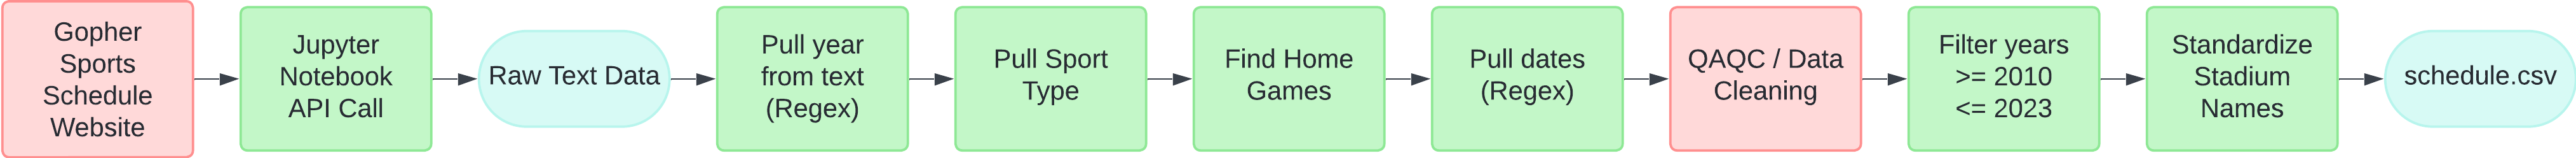

In [35]:
import os
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
file_path_db = file_path + '\\Sports_Data'
arcpy.env.workspace = file_path_db

In [42]:
import csv
import time
from datetime import datetime
import subprocess
import re

# Function to adjust the year based on the month if it is a split-year season
def adjust_year(year_string, month_string):
    # Checks if the year is in split format, e.g., 2008-09
    if '-' in year_string:
        year_range = year_string.split('-')
        year1, year2 = map(int, year_range)
        # Adjusts the year according to specific conditions
        if year1 == 1899:  # If year1 is 1899, year2 will be 1900
            year_string = '1900'
        elif year1 == 1999:  # If year1 is 1999, year2 will be 2000
            year_string = '2000'
        elif str(year1).startswith('18'):  # If year1 starts with '18', add 1800 to year2
            year_string = str(year2 + 1800)
        elif str(year1).startswith('19'):  # If year1 starts with '19', add 1900 to year2
            year_string = str(year2 + 1900)
        elif str(year1).startswith('20'):  # If year1 starts with '20', add 2000 to year2
            year_string = str(year2 + 2000)
        # If the month is June or later, use year1
        if int(month_string) > 5:
            year_string = str(year1)
    return year_string

# Initialize a list to store all sport rows
all_data_rows = []
# Define the range of all games
sport_numbers = list(range(1, 800))
# Loop to go through the sport text schedules and pull out rows
for game_code in sport_numbers:
    # URL for displaying the sport schedule in text; the game code changes the schedule
    url = f"https://gophersports.com/services/schedule_txt.ashx?schedule={game_code}"
    print(game_code)
    # Retry until the text content is fetched successfully, often providing many 404 errors
    while True:
        # Send a request to the URL using curl
        curl_proc = subprocess.Popen(['curl', '-s', url], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        response, error = curl_proc.communicate()
        # Check if the request was successful; if so, continue with the code
        if curl_proc.returncode == 0:
            # Split the text content by a new line to get each line
            lines = response.decode('utf-8').split("\n")
            try:
                # Get the second row of the text; this contains the sport and year
                second_row = lines[1].strip()
            except IndexError:
                # Prevent the code from breaking if the text page has no schedule
                print(f"Index Error for {game_code}. No Schedule")
                break  # Move to the next game code if an index error occurs
            # Look for a year value within the year and season
            year_string_match = re.match(r'(\d{4}-\d{2}|\d{4})', second_row)
            # Ensure the year was pulled successfully
            year_string = year_string_match.group(1) if year_string_match else None
            # Quality control: remove 'Schedule' from the end of the season column; only names sports and year
            season = second_row.replace("Schedule", "").strip()
            # Quality control: check if the season contains the busier sports
            if any(sport in season for sport in ["Football", "Volleyball", "Men's Basketball", "Men's Hockey", "Men's Ice Hockey"]):
                # Skip the first 10 rows; they are not in the right format
                for line in lines[10:]:
                    # Strip whitespace and split the line based on multiple spaces
                    data = re.split(r'\s{2,}', line.strip())
                    # Quality control: check if the row has more than 2 elements and the third element is a Home game
                    if len(data) > 2 and data[2] not in ["Away", "Neutral"]:
                        # Append the split data to data_rows with the year and season values added
                        if data[0] != "Date" or data[1] != "Time":  # Add this condition to select rows with "Date" and "Time"
                            # Extract only the date part without the day of the week; goes from Oct 10 (Fri) to Oct 10
                            date_without_day = re.sub(r'\s*\([^)]*\)', '', data[0])
                            # Extract the month from the date; add 2000 so it will accept Leap Year dates; does not impact the year as the year is pulled from line 2
                            month_string = datetime.strptime(date_without_day + " 2000", "%b %d %Y").strftime("%m")
                            # Adjust the year based on the month
                            year_string_for_row = adjust_year(year_string, month_string)
                            # Combine the date with the year and format it as "mm/dd/yyyy"
                            combined_date = datetime.strptime(f"{date_without_day} {year_string_for_row}", "%b %d %Y").strftime("%m/%d/%Y")
                            # Put the date in the first column
                            data[0] = combined_date
                            # Add a column for the year and season
                            all_data_rows.append([year_string_for_row, season] + data)
            break  # Exit the loop if the data is fetched successfully
        else:
            # Print an error message if the request was not successful
            print(f"Error: {error.decode('utf-8')} at {url}")
        # Wait for 0 seconds before retrying
        time.sleep(0)
    
# Write all games to a CSV file
output_filename = f"schedule_all.csv"
with open(output_filename, "w", newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header row with the columns we want
    writer.writerow(["Year", "Season", "Date", "Time", "At", "Opponent", "Location", "Score"])
    # Write the data rows for all games extracted
    writer.writerows(all_data_rows)

print(f"Data written to '{output_filename}'")


1
2
3
Index Error for 3. No Schedule
4
Index Error for 4. No Schedule
5
Index Error for 5. No Schedule
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254

## Data Cleaning

In [45]:
# Define the path to the initial schedule CSV file
initial_schedule_path = "schedule_all.csv"

# Load the initial schedule from CSV into a DataFrame
initial_schedule_df = pd.read_csv(initial_schedule_path)

# Exclude events with undefined locations (TBD)
no_undefined_location_df = initial_schedule_df[~initial_schedule_df['Location'].str.contains('TBD')].copy()

# Keep only rows with specific time formats, excluding placeholders like 'TBA' or 'TBD'
valid_time_events_df = no_undefined_location_df[~no_undefined_location_df['Time'].str.contains(r'^[^0-9]*$', regex=True)].copy()

# Filter out events not in the target states by excluding certain state abbreviations
target_state_events_df = valid_time_events_df[~valid_time_events_df['Location'].str.contains('Calif.|Ind.|Colo.')]

# Restrict the dataset to events between 2010 and 2023, aligning with traffic history data QA/QC
time_filtered_events_df = target_state_events_df[(target_state_events_df['Year'] >= 2010) & (target_state_events_df['Year'] <= 2023)]

# Standardize specific stadium names for consistency QA/QC
time_filtered_events_df.loc[time_filtered_events_df['Location'] == 'TCF Bank Stadium', 'Location'] = 'Huntington Bank Stadium'
time_filtered_events_df.loc[time_filtered_events_df['Location'] == 'Mariucci Arena', 'Location'] = '3M Arena at Mariucci'
time_filtered_events_df.loc[time_filtered_events_df['Location'] == 'Sports Pavilion', 'Location'] = 'Maturi Pavilion'

# Clean up the 'Location' column by removing specific patterns and extracting meaningful names
time_filtered_events_df['Location'] = time_filtered_events_df['Location'].str.replace(r'\bTBD \((.+?)\)', r'\1', regex=True)
time_filtered_events_df['Location'] = time_filtered_events_df['Location'].str.replace(r'.*\((.*)\).*', r'\1', regex=True)

# Simplify the 'Season' column by removing years and specific labels
time_filtered_events_df['Season'] = time_filtered_events_df['Season'].str.replace(r'\d+|-', '', regex=True)
time_filtered_events_df['Season'] = time_filtered_events_df['Season'].str.replace(r"Men's|Women's|Ice", '', regex=True)

# Remove the 'Score' column as it is no longer necessary for our analysis
time_filtered_events_df.drop('Score', axis=1, inplace=True)

# Specify the path for saving the cleaned and filtered schedule data
cleaned_schedule_path = "qaqc_schedule.csv"

# Write the cleaned and filtered schedule data to a new CSV file
time_filtered_events_df.to_csv(cleaned_schedule_path, index=False)

# Confirm the successful writing of the filtered data to the file
print(f"Filtered data written to '{cleaned_schedule_path}'")

[45]:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[45]:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[45]:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[45]:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Filtered data written to 'qaqc_schedule.csv'
